# Group G -  Fairness Project Submission

note: This is a merge of all the notebooks and utility files we have worked in. The processes follow each other so the code should be runnable (we tested it), however we have not rerun the API calls to the services, so there might be some missing output under those cells. Furthermore the saving of the built dataframes is commented out, so we do not overwrite the already existing files.

## Utility functions

In [9]:
from pathlib import Path
import pandas as pd
from os import listdir
import numpy as np
import matplotlib.pyplot as plt

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from typing import Dict, List, Iterator, NamedTuple, Tuple

In [5]:
def parse_azure_creds() -> Dict[str, str]:
    """
    Parses azure credentials
    only works if you have the azure cognitive credential in the file 
    """
    creds_dict: Dict = dict()
    creds_path: Path = Path.cwd().parent.joinpath('creds').joinpath('azure_creds.txt')
    with open(creds_path, 'r') as f:
        creds_dict['endpoint'] = f.readline().strip()
        creds_dict['region'] = f.readline().strip()
        creds_dict['key'] = f.readline().strip()
    return creds_dict
        

def get_visionclient() -> ComputerVisionClient:
    """
    builds azure visionclient
    """
    creds: Dict[str, str] = parse_azure_creds()
    vision_client : ComputerVisionClient = ComputerVisionClient(creds.get('endpoint'), CognitiveServicesCredentials(creds.get('key')))
    return vision_client

def get_valdf() -> pd.DataFrame:
    """
    Read and return validation dataframe 
    """
    path: Path = Path.cwd().parent.joinpath('data').joinpath('fairface_label_val.csv')
    return pd.read_csv(path)

def get_azuredf() -> pd.DataFrame:
    """
    Read and return azure classified dataframe
    """
    path: Path = Path.cwd().parent.joinpath('data').joinpath('azure_analyzed.csv')
    return pd.read_csv(path)

def get_azured_val() -> pd.DataFrame:
    """
    Read and return the merged azure and validation dataframe
    """
    path: Path = Path.cwd().parent.joinpath('data').joinpath('azure_val_merged.csv')
    return pd.read_csv(path)

def get_aws_val_df() -> pd.DataFrame:
    """
    Read and return the merged aws and validation dataframe
    """
    path: Path = Path.cwd().parent.joinpath('data').joinpath('aws_val_merged.csv')
    return pd.read_csv(path)

def get_images() -> List[Path]:
    """
    Iterator to loop through the face images
    """
    folder_path: Path = Path.cwd().parent.joinpath('data').joinpath('val')
    return (folder_path.joinpath(x) for x in listdir(folder_path))


## Gather Azure data

In [3]:
vs_client = get_visionclient()
val_df = get_valdf()
images = get_images()

In [4]:
# struct to save analysis results into
class FaceAnalysis(NamedTuple):
    path: str
    age: int
    gender: str

In [5]:
# function to work on one picture
features = [VisualFeatureTypes.faces]

def analyze_image(path: Path) -> FaceAnalysis:
    short_path = '/'.join(str(path).split('/')[-2:])
    with open(path, 'rb') as image_data:
        analysis = vs_client.analyze_image_in_stream(image_data, features)
    
    if analysis.faces:
        face = analysis.faces[0]
        return FaceAnalysis(path=short_path, age=face.age, gender=face.gender.name)
    else:
        return FaceAnalysis(path=short_path, age=None, gender=None)

In [6]:
# building the actual dataframe
paths, ages, genders = [], [], []
for idx, im in enumerate(images):
    if idx % 100 == 0:
        print(idx) # to keep track of speed
        break
    face = analyze_image(im)
    paths.append(face.path)
    ages.append(face.age)
    genders.append(face.gender)

0


In [7]:
azure_analyzed_df = pd.DataFrame({'path': paths, 'predicted_age': ages, 'predicted_gender': genders})
# we do not save the file here 
#analyzed_df.to_csv('azure_analyzed.csv', index = False)

In [8]:
# merge and save 
#val_df.merge(azure_analyzed_df, left_on = 'file', right_on = 'path').to_csv('azure_val_merged.csv')

## Gather Amazon data

In [9]:
import boto3
from rekognition_objects import RekognitionFace # source: https://docs.aws.amazon.com/code-samples/latest/catalog/python-rekognition-rekognition_objects.py.html

In [10]:
images = get_images()
# aws handles age as tuples, so redefinition of the class
class FaceAnalysis(NamedTuple):
    path: str
    age: Tuple[int, int]
    gender: str

rekognition_client = boto3.client('rekognition')

In [11]:
# func to analyze one picture
def aws_analyze_image(path: Path) -> FaceAnalysis:
    short_path = '/'.join(str(path).split('/')[-2:])
    try:
        with open(path, 'rb') as image_data:
            image = {'Bytes': image_data.read()}
            response = rekognition_client.detect_faces(Image = image, Attributes = ['ALL'])
            faces = [RekognitionFace(face) for face in response['FaceDetails']]
            face = faces[0]
            return FaceAnalysis(path=short_path, age=face.age_range, gender=face.gender)
    except:
        return FaceAnalysis(path=short_path, age=None, gender=None)

In [12]:
paths, ages, genders = [], [], []
for idx, im in enumerate(images):
    if idx % 10 == 9:
        print(idx)
        break
    face = aws_analyze_image(im)
    paths.append(face.path)
    ages.append(face.age)
    genders.append(face.gender)

9


In [13]:
analyzed_aws_df = pd.DataFrame({'path': paths, 'predicted_age': ages, 'predicted_gender': genders})

In [14]:
# save the merged df
#val_df.merge(analyzed_aws_df, left_on = 'file', right_on = 'path').to_csv('aws_val_merged.csv', index = False)

## Analysis of the results

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def calc_prop(data, group_col, group, output_col, output_val):
    new = data[data[group_col] == group]
    return len(new[new[output_col] == output_val])/len(new)

In [17]:
def perf_measure(data, y_actual, y_hat, prv, unprv):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==prv:
           TP += 1
        if y_hat[i]==prv and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==unprv:
           TN += 1
        if y_hat[i]==unprv and y_actual[i]!=y_hat[i]:
           FN += 1
    FN += (data.predicted_gender[data.gender == prv].isna()).sum()

    return TP, FP, TN, FN 

In [18]:
def Equality_of_odds(data, y_actual, y_hat, prv, unprv):
    TP, FP, TN, FN = perf_measure(data, y_actual, y_hat, prv, unprv)
    
    FNR = FN/(FN+TP)
    TPR = TP/(TP+FN)
    
    return FNR, TPR

In [19]:
def get_metrics(data, prv, unprv):
    nan_data = data[data.predicted_gender.isna()]
    prv_nones = (nan_data.gender == prv).sum()
    unprv_nones  = (nan_data.gender == unprv).sum()

    
    print(f'{prv} faces not detected: {prv_nones}')
    print(f'{unprv} faces not detected: {unprv_nones}')
    
    pr_priv = calc_prop(data, "gender", prv, "predicted_gender", prv)
    pr_unpriv = calc_prop(data, "gender", unprv, "predicted_gender", unprv)
    print(f'Disparate impact for unpriveliged {unprv} and priveliged {prv}: {float(pr_unpriv / pr_priv):.4}')
    print(f'Disparate impact for unpriveliged {prv} and priveliged {unprv}: {float(pr_priv / pr_unpriv):.4}')
    
    y_actual = data.gender.to_list()
    y_hat = data.predicted_gender.to_list()
    
    FNR, prv_TPR= Equality_of_odds(data, y_actual, y_hat, prv, unprv)
    print(f'Equality of odds:\n True positive rate: {prv_TPR:.4}, false positive rate: {FNR:.4} for {prv}')
    
    FNR, unprv_TPR = Equality_of_odds(data, y_actual, y_hat, unprv, prv)
    print(f' True positive rate: {unprv_TPR:.4}, false positive rate: {FNR:.4} for {unprv}')
    
    print(f'Equality of opportunity difference for {prv} and {unprv}: {float(unprv_TPR - prv_TPR):.4}')
    print(f'Equality of opportunity difference for {unprv} and {prv}: {float(prv_TPR - unprv_TPR):.4}')

### Azure part

In [10]:
data = get_azured_val()

In [21]:
data.predicted_gender[data.predicted_gender == 'male'] = 'Male'
data.predicted_gender[data.predicted_gender == 'female'] = 'Female'

<ipython-input-21-2d44442f7320>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.predicted_gender[data.predicted_gender == 'male'] = 'Male'
<ipython-input-21-2d44442f7320>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.predicted_gender[data.predicted_gender == 'female'] = 'Female'


In [22]:
get_metrics(data, 'Male', 'Female')

Male faces not detected: 1165
Female faces not detected: 777
Disparate impact for unpriveliged Female and priveliged Male: 1.114
Disparate impact for unpriveliged Male and priveliged Female: 0.8978
Equality of odds:
 True positive rate: 0.726, false positive rate: 0.274 for Male
 True positive rate: 0.8086, false positive rate: 0.1914 for Female
Equality of opportunity difference for Male and Female: 0.0826
Equality of opportunity difference for Female and Male: -0.0826


In [23]:
get_metrics(data.dropna(), 'Male', 'Female')

Male faces not detected: 0
Female faces not detected: 0
Disparate impact for unpriveliged Female and priveliged Male: 1.047
Disparate impact for unpriveliged Male and priveliged Female: 0.9547
Equality of odds:
 True positive rate: 0.9088, false positive rate: 0.0912 for Male
 True positive rate: 0.9519, false positive rate: 0.04812 for Female
Equality of opportunity difference for Male and Female: 0.04309
Equality of opportunity difference for Female and Male: -0.04309


### AWS part

In [24]:
data = get_aws_val_df()

In [26]:
get_metrics(data, 'Male', 'Female')

Male faces not detected: 108
Female faces not detected: 48
Disparate impact for unpriveliged Female and priveliged Male: 1.152
Disparate impact for unpriveliged Male and priveliged Female: 0.8681
Equality of odds:
 True positive rate: 0.797, false positive rate: 0.203 for Male
 True positive rate: 0.9181, false positive rate: 0.08194 for Female
Equality of opportunity difference for Male and Female: 0.1211
Equality of opportunity difference for Female and Male: -0.1211


In [27]:
get_metrics(data.dropna(), 'Male', 'Female')

Male faces not detected: 0
Female faces not detected: 0
Disparate impact for unpriveliged Female and priveliged Male: 1.141
Disparate impact for unpriveliged Male and priveliged Female: 0.8764
Equality of odds:
 True positive rate: 0.8121, false positive rate: 0.1879 for Male
 True positive rate: 0.9267, false positive rate: 0.07333 for Female
Equality of opportunity difference for Male and Female: 0.1146
Equality of opportunity difference for Female and Male: -0.1146


In [29]:
data.shape

(10954, 8)

### Plot race distribution

In [7]:
non_data = data[data.predicted_gender.isna()]

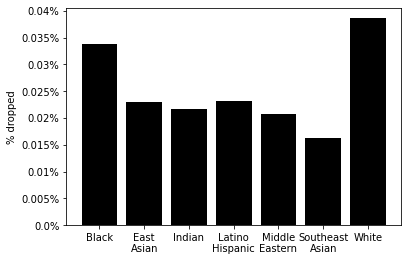

In [11]:
values = non_data.groupby(by = 'race').size().values / sum(data.groupby(by = 'race').size().values)
ranges = np.round(np.arange(0, 0.045, 0.005), decimals = 3)

plt.bar(data.groupby(by = 'race').size().index, values, align = 'center', color = 'black')
plt.xticks(ticks=[i for i in range(7)], labels = ['Black', 'East\nAsian', 'Indian', 'Latino\nHispanic', 'Middle\nEastern','Southeast\nAsian', 'White']) #, rotation=45)
plt.yticks(ticks=[i for i in ranges], labels = [f'{i}%' for i in ranges])
plt.ylabel('% dropped')
# plt.savefig('dropped_race.png',  bbox_inches = 'tight')
plt.show()

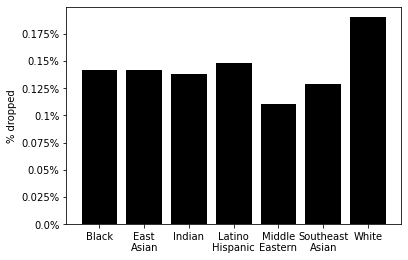

In [12]:
values =  data.groupby(by = 'race').size().values / sum( data.groupby(by = 'race').size().values)
ranges = np.round(np.arange(0, 0.2, 0.025), decimals = 3)
plt.bar(data.groupby(by = 'race').size().index,  values, align = 'center', color = 'black')
plt.xticks(ticks=[i for i in range(7)], labels = ['Black', 'East\nAsian', 'Indian', 'Latino\nHispanic', 'Middle\nEastern','Southeast\nAsian', 'White']) #, rotation=45)
plt.yticks(ticks=[i for i in ranges], labels = [f'{i}%' for i in ranges])
plt.ylabel('% dropped')
# plt.savefig('race_dist.png', bbox_inches = 'tight')
plt.show()